In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

allfiles = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        allfiles.append(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.5 MB/s eta 0:00:00


In [3]:
import random

trainind = int(.8*len(allfiles))
valind = int(trainind + .1*len(allfiles))

print(trainind, valind, len(allfiles))

random.shuffle(allfiles)

trainset = allfiles[:trainind]
valset = allfiles[trainind:valind]
testset = allfiles[trainind:valind]

print(trainset[0])

7366 8286 9208
/kaggle/input/3-kinds-of-pneumonia/Curated X-Ray Dataset/Pneumonia-Viral/Pneumonia-Viral (1185).jpg


In [4]:
import torchvision.transforms as transforms

In [5]:
from PIL import Image
import torch
import torch.utils.data.dataset

img_size = (224,224)
batch_size = 8
max_epochs = 10
device = 'cuda'
"""
user configuration
"""

train_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = img_size),
#     transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

class TargetTran:
    def __init__(self):
        self.cat = {
            'COVID-19':0,
            'Normal': 1,
            'Pneumonia-Bacterial': 2,
            'Pneumonia-Viral': 3
        }
    def __call__(self, x):
        """
        x is the path for the image. the path has information about the label
        """
        class_str = x.split('/')[-2]
        return self.cat[class_str]

class CustomDataset:
    def __init__(self, pathlist, transformation = None, targettrans = None):
        """
        transformation: this converts from file path to image tensor
        targettrans: this converts from file path to label
        """
        self.pathlist = pathlist
        self.transformation = transformation
        self.targettrans = targettrans
        
    def __len__(self):
        return len(self.pathlist)
    
    def __getitem__(self,idx):
        path = self.pathlist[idx]
        image_pil = Image.open(path).convert('RGB')
        image = self.transformation(image_pil)
        class_ = self.targettrans(path)
        return image, class_

In [6]:
# # TEST CASES
target_trans = TargetTran() # we need to make a actual class and parse to the function.
# train_ds = CustomDataset(trainset, train_trans, target_trans)

import tqdm
# list_labels = []
# list_shape = []
# for d in tqdm.tqdm(train_ds):
#     list_shape.append(d[0].shape)
#     list_labels.append(d[1])
    
# print(set([str(shape) for shape in list_shape]))
# pd.value_counts(list_labels)

## This works properly

In [7]:
train_ds = CustomDataset(trainset, train_trans, target_trans)
#val_ds = CustomDataset(valset, train_trans, target_trans)
test_ds = CustomDataset(testset, train_trans, target_trans)

dataloaders = {
    'train': torch.utils.data.DataLoader(train_ds, batch_size = 8, num_workers = 2, shuffle = True),
    #'val': torch.utils.data.DataLoader(val_ds, batch_size = 8, num_workers = 2, shuffle = False),
    'test': torch.utils.data.DataLoader(test_ds, batch_size = 8, num_workers = 2, shuffle = False),
}

In [8]:
# TEST CASES


In [9]:
# Using pretrained model
import torchvision

net = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [10]:
# TEST CASES

import torch.nn as nn


x = next(iter(dataloaders['train']))[0]
features = net.features(x)
out = net(x)
print(features.shape, out.shape)

# Define new classifier
net.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=1000, bias=True),
    nn.ReLU(inplace = True),
    nn.Dropout(p = 0.5, inplace = False),
    nn.Linear(in_features=1000, out_features = 4, bias = True)
)

# TEST CASESlist_pred.extend(torch.argmax(out, dim = 1).cpu().detach().numpy().tolist())
#         list_real.extend(label.cpu().detach().numpy().tolist())
x = next(iter(dataloaders['train']))[0]
features = net.features(x)
out = net(x)
print(features.shape, out.shape)

torch.Size([8, 512, 7, 7]) torch.Size([8, 1000])
torch.Size([8, 512, 7, 7]) torch.Size([8, 4])


In [11]:
# Using pretrained model
import torchvision

net = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)

net.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=1000, bias=True),
    nn.ReLU(inplace = True),
    nn.Dropout(p = 0.5, inplace = False),
    nn.Linear(in_features=1000, out_features = 4, bias = True)
)
net.to(device)
net.train()
for p in net.parameters():
    p.requires_grad = True
optimizer = torch.optim.Adam(net.parameters(), lr = 0.0001)

loss_fn = nn.CrossEntropyLoss()

In [12]:
# Train
list_loss_epoch = []
acc_list = []
for epoch in range(max_epochs):
    list_loss = []
    list_pred = []
    list_real = []
    # Train
    net.train()
    pbar = tqdm.tqdm(total = len(dataloaders['train']), desc = f"Train ({epoch + 1}/{max_epochs})", position = 0)
    for batch in dataloaders['train']:
        image = batch[0].to(device)
        label = batch[1].to(device)
        # set gradient to 0
        net.zero_grad()
        # feed forward
        out = net(image)
        # get loss
        loss = loss_fn(out, label)
        # get gradients
        loss.backward()
        # update gradient
        optimizer.step()
        # Save record and report
        loss_report = loss.item() # loss.item() returns value of the loss to cpu memory
        list_loss.append(loss_report)
        pbar.update(1)
        pbar.set_postfix({'loss': f"{np.mean(list_loss):.2f}"})
        list_loss_epoch.append(np.mean(list_loss))
        list_pred.extend(torch.argmax(out, dim = 1).cpu().detach().numpy().tolist())
        list_real.extend(label.cpu().detach().numpy().tolist())
    avg_acc = np.mean(np.array(list_pred) == np.array(list_real))
    pbar.set_postfix({'loss': f'{np.mean(list_loss):.2f}', 'train_acc': f'{avg_acc:.2f}'})
    pbar.close()
    # Validation
    net.eval() # net.eval() randomness is dropped from the model
    list_loss = []
    list_pred = []
    list_real = []
    
    with torch.no_grad():
        #set net
        
        #load data
        
        #calculate loss
        
        #collect learning process
        
        #report
        
        pass
    
# At the end of training - you want to get a test score
# Performance analysis (F-1 score, Accuracy, confusion matrix...)

Train (10/10): 100%|██████████| 921/921 [04:30<00:00,  3.41it/s, loss=0.09, train_acc=0.97]


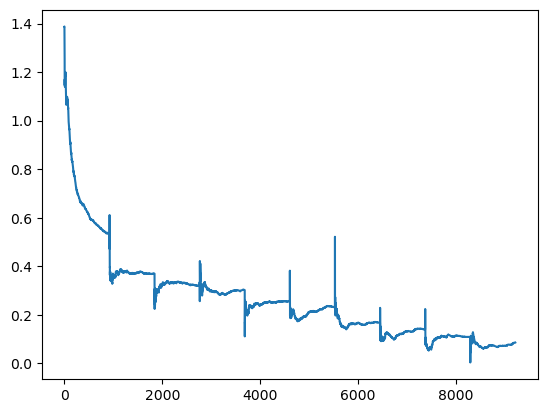

In [13]:
import matplotlib.pyplot as plt

plt.plot(np.array(list_loss_epoch))
plt.show()

In [14]:
test_list_pred=[]
test_list_real=[]

pbar = tqdm.tqdm(total = len(dataloaders['test']), position = 0, desc = f"test:")

#Testing Section

with torch.no_grad():
    for batch in dataloaders['train']:        #testing loop
        #plug and chug section
        image = batch[0].to(device)
        label = batch[1].to(device)
        out = net(image)
        #collect accuracy 
        test_list_pred.append(torch.argmax(out, dim = 1).cpu().detach().numpy().tolist())   #ValueError: zero-dimensional arrays cannot be concatenated
        test_list_real.append(label.cpu().detach().numpy().tolist())
        
        pbar.update(1)
        
pbar.close()
test_list_pred = np.concatenate(test_list_pred)
test_list_real = np.concatenate(test_list_real)
simple_acc = (test_list_pred == test_list_real).mean()
print(simple_acc)

        
        

test:: 921it [03:32,  4.33it/s]

0.9804507195221287


In [15]:
from sklearn.metrics import confusion_matrix
